#### Auteur: Irina Maslowski

### Projet N° 4. Segmentez des clients d'un site e-commerce

Evaluation de la fréquence à laquelle la segmentation doit être mise à jour, afin de pouvoir effectuer un devis de contrat de maintenance.

In [2]:
import pandas as pd
import numpy as np
import matplotlib as mpl
import matplotlib.pyplot as plt
import seaborn as sns
import scipy.stats as st
import datetime as dt

In [58]:
from time import time
import sklearn
from sklearn.pipeline import make_pipeline
from sklearn import preprocessing
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import MaxAbsScaler
from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import RobustScaler, QuantileTransformer

In [59]:
from sklearn import metrics
from sklearn.metrics import davies_bouldin_score
from sklearn.metrics import pairwise_distances
from sklearn.metrics import silhouette_samples, silhouette_score

In [60]:
from sklearn.cluster import KMeans
from yellowbrick.cluster import KElbowVisualizer, SilhouetteVisualizer
import matplotlib.cm as cm
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE
from sklearn.cluster import AgglomerativeClustering
from collections import OrderedDict
from scipy.cluster.hierarchy import dendrogram

In [84]:
from sklearn.metrics.cluster import adjusted_rand_score

In [183]:
! pip install plotly

  Created wheel for retrying: filename=retrying-1.3.3-py3-none-any.whl size=11434 sha256=afd26f2d24d6bfd876f6c8a359aa1fbbad5d4587c33d42da5c4f6a9607b31cec
  Stored in directory: c:\users\piari\appdata\local\pip\cache\wheels\c4\a7\48\0a434133f6d56e878ca511c0e6c38326907c0792f67b476e56
Successfully built retrying


In [184]:
import plotly.graph_objects as go

In [3]:
df_olist_ecommerce = pd.read_excel('C:/Users/piari/Documents/Projet4_ecommerce/df_olist_ecommerce.xlsx')

In [20]:
df_olist_ecommerce.columns

Index(['order_id', 'customer_id', 'order_status', 'order_purchase_timestamp',
       'order_approved_at', 'order_delivered_carrier_date',
       'order_delivered_customer_date', 'order_estimated_delivery_date',
       'customer_unique_id', 'customer_zip_code_prefix', 'customer_city',
       'customer_state', 'order_item_id', 'product_id', 'seller_id',
       'shipping_limit_date', 'price', 'freight_value',
       'seller_zip_code_prefix', 'seller_city', 'seller_state',
       'product_name_lenght', 'product_description_lenght',
       'product_photos_qty', 'product_weight_g', 'product_category_name',
       'payment_sequential', 'payment_type', 'payment_installments',
       'payment_value', 'review_id', 'review_score', 'review_creation_date',
       'review_answer_timestamp', 'contain_message', 'delta_date_order',
       'customer_seller_distance', 'customer_seller_distance_inferior50km',
       'customer_seller_distance_51km-100km',
       'customer_seller_distance_101km-1000km',
   

In [21]:
df_olist_ecommerce_reduced = df_olist_ecommerce.drop(['customer_zip_code_prefix', 'customer_city', 'customer_state',
                                                     'seller_zip_code_prefix', 'seller_city', 'seller_state',
                                                      'product_name_lenght', 'product_description_lenght', 'product_photos_qty',
                                                     'contain_message', 'delta_date_order',
                                                      'customer_seller_distance_inferior50km',
                                                      'customer_seller_distance_51km-100km',
                                                     'customer_seller_distance_101km-1000km',
                                                     'customer_seller_distance_1001km_plus', 'delivered',
                                                     'in_progress', 'unavailable', 'canceled'], axis=1)

In [22]:
df_olist_ecommerce_reduced.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 119151 entries, 0 to 119150
Data columns (total 30 columns):
 #   Column                         Non-Null Count   Dtype         
---  ------                         --------------   -----         
 0   order_id                       119151 non-null  object        
 1   customer_id                    119151 non-null  object        
 2   order_status                   119151 non-null  object        
 3   order_purchase_timestamp       119151 non-null  datetime64[ns]
 4   order_approved_at              118974 non-null  object        
 5   order_delivered_carrier_date   117065 non-null  object        
 6   order_delivered_customer_date  115730 non-null  datetime64[ns]
 7   order_estimated_delivery_date  119151 non-null  datetime64[ns]
 8   customer_unique_id             119151 non-null  object        
 9   order_item_id                  118318 non-null  float64       
 10  product_id                     118318 non-null  object        
 11  

In [23]:
df_olist_ecommerce_reduced['order_purchase_timestamp'].dt.year

0         2017
1         2017
2         2017
3         2018
4         2018
          ... 
119146    2018
119147    2017
119148    2018
119149    2018
119150    2018
Name: order_purchase_timestamp, Length: 119151, dtype: int64

In [24]:
df_olist_ecommerce_reduced['order_purchase_timestamp'].dt.year.min()

2016

In [25]:
df_olist_ecommerce_reduced['order_purchase_timestamp'].dt.year.max()

2018

In [26]:
_cpt = 1
df_olist_ecommerce['df_step'] = 0
for _year in (2017, 2018):
    for _month in range(4):
        _months = list(_month*3 + _i for _i in range(1,4))
        _mask = (df_olist_ecommerce_reduced['order_purchase_timestamp'].dt.year == _year) \
                & (df_olist_ecommerce_reduced['order_purchase_timestamp'].dt.month.isin(_months))
        df_olist_ecommerce_reduced.loc[_mask, 'df_step'] = _cpt
        _cpt += 1
df_olist_ecommerce_reduced[['order_purchase_timestamp','df_step']]

,order_purchase_timestamp,df_step
0,2017-10-02 10:56:33,4
1,2017-10-02 10:56:33,4
2,2017-10-02 10:56:33,4
3,2018-07-24 20:41:37,7
4,2018-08-08 08:38:49,7
...,...,...
119146,2018-02-06 12:58:58,5
119147,2017-08-27 14:46:43,3
119148,2018-01-08 21:28:27,5
119149,2018-01-08 21:28:27,5


In [27]:
df_olist_ecommerce_reduced.groupby('df_step').agg({'order_purchase_timestamp': ('count', 'min', 'max')})

order_purchase_timestamp                                        
                           count                 min                 max
df_step                                                                 
0                            410 2016-09-04 21:15:19 2016-12-23 23:16:47
1                           6401 2017-01-05 11:56:06 2017-03-31 23:54:45
2                          11216 2017-04-01 00:54:10 2017-06-30 23:20:08
3                          15414 2017-07-01 00:04:15 2017-09-30 23:59:15
4                          21521 2017-10-01 00:03:33 2017-12-31 23:29:31
5                          25330 2018-01-01 02:48:41 2018-03-31 23:54:10
6                          23939 2018-04-01 00:11:32 2018-06-30 23:59:49
7                          14916 2018-07-01 00:25:07 2018-09-29 09:13:03
8                              4 2018-10-01 15:30:09 2018-10-17 17:30:18

In [28]:
dataframes = list()
for _step in range(1, 8):
    _df = df_olist_ecommerce_reduced[df_olist_ecommerce_reduced['df_step'].isin(range(1, _step+1))].copy()
    print(f'size: {len(_df)}, min: {_df["order_purchase_timestamp"].min()}, max: {_df["order_purchase_timestamp"].max()}')
    _max_date = _df["order_purchase_timestamp"].max()
    _df['delta_date_order'] = _max_date - _df['order_purchase_timestamp']
    print(f'delta min: {_df["delta_date_order"].min()}, max: {_df["delta_date_order"].max()}')
    dataframes.append(_df)

size: 6401, min: 2017-01-05 11:56:06, max: 2017-03-31 23:54:45
delta min: 0 days 00:00:00, max: 85 days 11:58:39
size: 17617, min: 2017-01-05 11:56:06, max: 2017-06-30 23:20:08
delta min: 0 days 00:00:00, max: 176 days 11:24:02
size: 33031, min: 2017-01-05 11:56:06, max: 2017-09-30 23:59:15
delta min: 0 days 00:00:00, max: 268 days 12:03:09
size: 54552, min: 2017-01-05 11:56:06, max: 2017-12-31 23:29:31
delta min: 0 days 00:00:00, max: 360 days 11:33:25
size: 79882, min: 2017-01-05 11:56:06, max: 2018-03-31 23:54:10
delta min: 0 days 00:00:00, max: 450 days 11:58:04
size: 103821, min: 2017-01-05 11:56:06, max: 2018-06-30 23:59:49
delta min: 0 days 00:00:00, max: 541 days 12:03:43
size: 118737, min: 2017-01-05 11:56:06, max: 2018-09-29 09:13:03
delta min: 0 days 00:00:00, max: 631 days 21:16:57


In [31]:
# conteur de la valeur la plus fréquante
def most_frequent(x):
#     try:
#         return x.value_counts().index[0]
#     except:
#         print(x)
#     return
    _counts = x.value_counts()
    if len(_counts): 
        return _counts.index[0]
    return np.NaN

In [35]:
dataframes_customer = list()
for df in dataframes:
    df_sorted = df.sort_values(by=['order_purchase_timestamp'])
    dataframes_customer.append(df_sorted.groupby('customer_unique_id').agg({
    'order_id': ('nunique'),
    'order_purchase_timestamp': ('min', 'max'),
    'delta_date_order': ('first', 'last'),
    'freight_value': ('max'),
    'payment_type': (most_frequent),
    'product_category_name': (most_frequent),
    'payment_value': ('sum'),
    'product_id': ('count'),
    'review_score': ('min'),
    'delivery_period': ('max'),
    'product_volume_cm3' : (most_frequent),
    'intime_delivery' : ('mean')
}))

In [37]:
dataframes_customer[0]

order_id order_purchase_timestamp  \
                                  nunique                      min   
customer_unique_id                                                   
0000f46a3911fa3c0805444483337064        1      2017-03-10 21:05:03   
0005e1862207bf6ccc02e4228effd9a0        1      2017-03-04 23:32:12   
00115fc7123b5310cf6d3a3aa932699e        1      2017-01-21 21:58:35   
001f3c4211216384d5fe59b041ce1461        1      2017-03-19 18:34:36   
002043098f10ba39a4600b6c52fbfe3c        1      2017-03-26 16:45:59   
...                                   ...                      ...   
ffe2dd1f3b0cbf0b5f35e818ec03c49b        1      2017-03-05 21:23:38   
ffe3e199b9d0b7fb7d2d29a5b9498447        1      2017-03-15 17:16:36   
ffebb6424578e7bb153322da9d65634f        1      2017-01-16 14:04:11   
ffedff0547d809c90c05c2691c51f9b7        1      2017-03-30 14:50:26   
ffff371b4d645b6ecea244b27531430a        1      2017-02-07 15:49:16   

                                                     delta_date_order  \
                                                 max            first   
customer_unique_id                                                      
0000f46a3911fa3c0805444483337064 2017-03-10 21:05:03 21 days 02:49:42   
0005e1862207bf6ccc02e4228effd9a0 2017-03-04 23:32:12 27 days 00:22:33   
00115fc7123b5310cf6d3a3aa932699e 2017-01-21 21:58:35 69 days 01:56:10   
001f3c4211216384d5fe59b041ce1461 2017-03-19 18:34:36 12 days 05:20:09   
002043098f10ba39a4600b6c52fbfe3c 2017-03-26 16:45:59  5 days 07:08:46   
...                                              ...              ...   
ffe2dd1f3b0cbf0b5f35e818ec03c49b 2017-03-05 21:23:38 26 days 02:31:07   
ffe3e199b9d0b7fb7d2d29a5b9498447 2017-03-15 17:16:36 16 days 06:38:09   
ffebb6424578e7bb153322da9d65634f 2017-01-16 14:04:11 74 days 09:50:34   
ffedff0547d809c90c05c2691c51f9b7 2017-03-30 14:50:26  1 days 09:04:19   
ffff371b4d645b6ecea244b27531430a 2017-02-07 15:49:16 52 days 08:05:29   

                                                  freight_value  payment_type  \
                                             last           max most_frequent   
customer_unique_id                                                              
0000f46a3911fa3c0805444483337064 21 days 02:49:42         17.22   credit_card   
0005e1862207bf6ccc02e4228effd9a0 27 days 00:22:33         15.12   credit_card   
00115fc7123b5310cf6d3a3aa932699e 69 days 01:56:10         16.12   credit_card   
001f3c4211216384d5fe59b041ce1461 12 days 05:20:09         10.96   credit_card   
002043098f10ba39a4600b6c52fbfe3c  5 days 07:08:46         60.82   credit_card   
...                                           ...           ...           ...   
ffe2dd1f3b0cbf0b5f35e818ec03c49b 26 days 02:31:07         20.71   credit_card   
ffe3e199b9d0b7fb7d2d29a5b9498447 16 days 06:38:09         15.20        boleto   
ffebb6424578e7bb153322da9d65634f 74 days 09:50:34         36.70   credit_card   
ffedff0547d809c90c05c2691c51f9b7  1 days 09:04:19         14.52   credit_card   
ffff371b4d645b6ecea244b27531430a 52 days 08:05:29         22.56   credit_card   

                                     product_category_name payment_value  \
                                             most_frequent           sum   
customer_unique_id                                                         
0000f46a3911fa3c0805444483337064                stationery         86.22   
0005e1862207bf6ccc02e4228effd9a0  fashion_bags_accessories        150.12   
00115fc7123b5310cf6d3a3aa932699e            sports_leisure         76.11   
001f3c4211216384d5fe59b041ce1461                housewares         35.84   
002043098f10ba39a4600b6c52fbfe3c          office_furniture        237.81   
...                                                    ...           ...   
ffe2dd1f3b0cbf0b5f35e818ec03c49b            bed_bath_table        110.70   
ffe3e199b9d0b7fb7d2d29a5b9498447         home_construction        162.10   
ffebb6424578e7bb153322da9d65634f                cool_stuff

In [38]:
for dfc in dataframes_customer:
    dfc['purchase_frequency'] = (dfc['delta_date_order']['first']-dfc['delta_date_order']['last'])/dfc['order_id']['nunique']
    dfc['average_consumer_basket'] = dfc['payment_value']['sum']/dfc['order_id']['nunique']
    dfc.columns = ['_'.join(col).strip() for col in dfc.columns.values]

In [39]:
dataframes_customer[0]

,order_id_nunique,order_purchase_timestamp_min,order_purchase_timestamp_max,delta_date_order_first,delta_date_order_last,freight_value_max,payment_type_most_frequent,product_category_name_most_frequent,payment_value_sum,product_id_count,review_score_min,delivery_period_max,product_volume_cm3_most_frequent,intime_delivery_mean,purchase_frequency_,average_consumer_basket_
customer_unique_id,,,,,,,,,,,,,,,,
0000f46a3911fa3c0805444483337064,1,2017-03-10 21:05:03,2017-03-10 21:05:03,21 days 02:49:42,21 days 02:49:42,17.22,credit_card,stationery,86.22,1,3,25.731759,0.043750,1.389734,0 days,86.22
0005e1862207bf6ccc02e4228effd9a0,1,2017-03-04 23:32:12,2017-03-04 23:32:12,27 days 00:22:33,27 days 00:22:33,15.12,credit_card,fashion_bags_accessories,150.12,1,4,4.375648,0.006600,27.643657,0 days,150.12
00115fc7123b5310cf6d3a3aa932699e,1,2017-01-21 21:58:35,2017-01-21 21:58:35,69 days 01:56:10,69 days 01:56:10,16.12,credit_card,sports_leisure,76.11,1,4,10.999317,0.009280,32.085000,0 days,76.11
001f3c4211216384d5fe59b041ce1461,1,2017-03-19 18:34:36,2017-03-19 18:34:36,12 days 05:20:09,12 days 05:20:09,10.96,credit_card,housewares,35.84,1,3,10.546516,0.000352,10.679456,0 days,35.84
002043098f10ba39a4600b6c52fbfe3c,1,2017-03-26 16:45:59,2017-03-26 16:45:59,5 days 07:08:46,5 days 07:08:46,60.82,credit_card,office_furniture,237.81,1,4,23.703519,0.068970,15.597882,0 days,237.81
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
ffe2dd1f3b0cbf0b5f35e818ec03c49b,1,2017-03-05 21:23:38,2017-03-05 21:23:38,26 days 02:31:07,26 days 02:31:07,20.71,credit_card,bed_bath_table,110.70,1,4,12.565347,0.015000,8.543241,0 days,110.70
ffe3e199b9d0b7fb7d2d29a5b9498447,1,2017-03-15 17:16:36,2017-03-15 17:16:36,16 days 06:38:09,16 days 06:38:09,15.20,boleto,home_construction,162.10,1,1,21.063542,0.004320,-0.783403,0 days,162.10
ffebb6424578e7bb153322da9d65634f,1,2017-01-16 14:04:11,2017-01-16 14:04:11,74 days 09:50:34,74 days 09:50:34,36.70,credit_card,cool_stuff,665.70,1,1,37.624363,0.054144,4.789398,0 days,665.70


In [40]:
for dfc in dataframes_customer:
    dfc['spent_amount'] = dfc['average_consumer_basket_'] + dfc['freight_value_max']

In [41]:
dataframes_customer[0]

,order_id_nunique,order_purchase_timestamp_min,order_purchase_timestamp_max,delta_date_order_first,delta_date_order_last,freight_value_max,payment_type_most_frequent,product_category_name_most_frequent,payment_value_sum,product_id_count,review_score_min,delivery_period_max,product_volume_cm3_most_frequent,intime_delivery_mean,purchase_frequency_,average_consumer_basket_,spent_amount
customer_unique_id,,,,,,,,,,,,,,,,,
0000f46a3911fa3c0805444483337064,1,2017-03-10 21:05:03,2017-03-10 21:05:03,21 days 02:49:42,21 days 02:49:42,17.22,credit_card,stationery,86.22,1,3,25.731759,0.043750,1.389734,0 days,86.22,103.44
0005e1862207bf6ccc02e4228effd9a0,1,2017-03-04 23:32:12,2017-03-04 23:32:12,27 days 00:22:33,27 days 00:22:33,15.12,credit_card,fashion_bags_accessories,150.12,1,4,4.375648,0.006600,27.643657,0 days,150.12,165.24
00115fc7123b5310cf6d3a3aa932699e,1,2017-01-21 21:58:35,2017-01-21 21:58:35,69 days 01:56:10,69 days 01:56:10,16.12,credit_card,sports_leisure,76.11,1,4,10.999317,0.009280,32.085000,0 days,76.11,92.23
001f3c4211216384d5fe59b041ce1461,1,2017-03-19 18:34:36,2017-03-19 18:34:36,12 days 05:20:09,12 days 05:20:09,10.96,credit_card,housewares,35.84,1,3,10.546516,0.000352,10.679456,0 days,35.84,46.80
002043098f10ba39a4600b6c52fbfe3c,1,2017-03-26 16:45:59,2017-03-26 16:45:59,5 days 07:08:46,5 days 07:08:46,60.82,credit_card,office_furniture,237.81,1,4,23.703519,0.068970,15.597882,0 days,237.81,298.63
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
ffe2dd1f3b0cbf0b5f35e818ec03c49b,1,2017-03-05 21:23:38,2017-03-05 21:23:38,26 days 02:31:07,26 days 02:31:07,20.71,credit_card,bed_bath_table,110.70,1,4,12.565347,0.015000,8.543241,0 days,110.70,131.41
ffe3e199b9d0b7fb7d2d29a5b9498447,1,2017-03-15 17:16:36,2017-03-15 17:16:36,16 days 06:38:09,16 days 06:38:09,15.20,boleto,home_construction,162.10,1,1,21.063542,0.004320,-0.783403,0 days,162.10,177.30
ffebb6424578e7bb153322da9d65634f,1,2017-01-16 14:04:11,2017-01-16 14:04:11,74 days 09:50:34,74 days 09:50:34,36.70,credit_card,cool_stuff,665.70,1,1,37.624363,0.054144,4.789398,0 days,665.70,702.40


In [42]:
for dfc in dataframes_customer:
    dfc.rename(columns={"order_id_nunique": "purchase_number"}, inplace = True)

In [43]:
dataframes_customer[0].columns

Index(['purchase_number', 'order_purchase_timestamp_min',
       'order_purchase_timestamp_max', 'delta_date_order_first',
       'delta_date_order_last', 'freight_value_max',
       'payment_type_most_frequent', 'product_category_name_most_frequent',
       'payment_value_sum', 'product_id_count', 'review_score_min',
       'delivery_period_max', 'product_volume_cm3_most_frequent',
       'intime_delivery_mean', 'purchase_frequency_',
       'average_consumer_basket_', 'spent_amount'],
      dtype='object')

In [44]:
for dfc in dataframes_customer:
    dfc.drop(['order_purchase_timestamp_min', 'order_purchase_timestamp_max', 'payment_type_most_frequent',
              'product_category_name_most_frequent', 'payment_value_sum', 'product_id_count', 'delivery_period_max',
              'product_volume_cm3_most_frequent', 'average_consumer_basket_', 'freight_value_max'], axis=1, inplace = True)

In [45]:
dataframes_customer[0]

,purchase_number,delta_date_order_first,delta_date_order_last,review_score_min,intime_delivery_mean,purchase_frequency_,spent_amount
customer_unique_id,,,,,,,
0000f46a3911fa3c0805444483337064,1,21 days 02:49:42,21 days 02:49:42,3,1.389734,0 days,103.44
0005e1862207bf6ccc02e4228effd9a0,1,27 days 00:22:33,27 days 00:22:33,4,27.643657,0 days,165.24
00115fc7123b5310cf6d3a3aa932699e,1,69 days 01:56:10,69 days 01:56:10,4,32.085000,0 days,92.23
001f3c4211216384d5fe59b041ce1461,1,12 days 05:20:09,12 days 05:20:09,3,10.679456,0 days,46.80
002043098f10ba39a4600b6c52fbfe3c,1,5 days 07:08:46,5 days 07:08:46,4,15.597882,0 days,298.63
...,...,...,...,...,...,...,...
ffe2dd1f3b0cbf0b5f35e818ec03c49b,1,26 days 02:31:07,26 days 02:31:07,4,8.543241,0 days,131.41
ffe3e199b9d0b7fb7d2d29a5b9498447,1,16 days 06:38:09,16 days 06:38:09,1,-0.783403,0 days,177.30
ffebb6424578e7bb153322da9d65634f,1,74 days 09:50:34,74 days 09:50:34,1,4.789398,0 days,702.40


In [52]:
for dfc in dataframes_customer:
    dfc.dropna(inplace = True)

In [53]:
dataframes_customer[0]

,purchase_number,delta_date_order_first,delta_date_order_last,review_score_min,intime_delivery_mean,purchase_frequency_,spent_amount
customer_unique_id,,,,,,,
0000f46a3911fa3c0805444483337064,1,21 days 02:49:42,21 days 02:49:42,3,1.389734,0 days,103.44
0005e1862207bf6ccc02e4228effd9a0,1,27 days 00:22:33,27 days 00:22:33,4,27.643657,0 days,165.24
00115fc7123b5310cf6d3a3aa932699e,1,69 days 01:56:10,69 days 01:56:10,4,32.085000,0 days,92.23
001f3c4211216384d5fe59b041ce1461,1,12 days 05:20:09,12 days 05:20:09,3,10.679456,0 days,46.80
002043098f10ba39a4600b6c52fbfe3c,1,5 days 07:08:46,5 days 07:08:46,4,15.597882,0 days,298.63
...,...,...,...,...,...,...,...
ffe2dd1f3b0cbf0b5f35e818ec03c49b,1,26 days 02:31:07,26 days 02:31:07,4,8.543241,0 days,131.41
ffe3e199b9d0b7fb7d2d29a5b9498447,1,16 days 06:38:09,16 days 06:38:09,1,-0.783403,0 days,177.30
ffebb6424578e7bb153322da9d65634f,1,74 days 09:50:34,74 days 09:50:34,1,4.789398,0 days,702.40


In [69]:
# transformation de timedelta en float
for dfc in dataframes_customer:
#     dfc['delta_date_order_first']=dfc['delta_date_order_first'].apply(lambda x:x.total_seconds())
#     dfc['delta_date_order_last']=dfc['delta_date_order_last'].apply(lambda x:x.total_seconds())
    dfc['purchase_frequency_']=dfc['purchase_frequency_'].apply(lambda x:x.total_seconds())

In [70]:
# les 7 dataframes résultant du découpage
df_customer_1tr, df_customer_2tr, df_customer_3tr, df_customer_4tr, df_customer_5tr, df_customer_6tr,
df_customer_7tr = dataframes_customer

In [148]:
# sauvegarde des 7 dataframes obtenus dans des fichiers xlsx
df_customer_1tr.to_excel("df_customer_1tr.xlsx", index=False)

In [149]:
df_customer_2tr.to_excel("df_customer_2tr.xlsx", index=False)

In [150]:
df_customer_3tr.to_excel("df_customer_3tr.xlsx", index=False)

In [151]:
df_customer_4tr.to_excel("df_customer_4tr.xlsx", index=False)

In [152]:
df_customer_5tr.to_excel("df_customer_5tr.xlsx", index=False)

In [153]:
df_customer_6tr.to_excel("df_customer_6tr.xlsx", index=False)

In [154]:
df_customer_7tr.to_excel("df_customer_7tr.xlsx", index=False)

In [71]:
df_customer_1tr

,purchase_number,delta_date_order_first,delta_date_order_last,review_score_min,intime_delivery_mean,purchase_frequency_,spent_amount
customer_unique_id,,,,,,,
0000f46a3911fa3c0805444483337064,1,1824582.0,1824582.0,3,1.389734,0.0,103.44
0005e1862207bf6ccc02e4228effd9a0,1,2334153.0,2334153.0,4,27.643657,0.0,165.24
00115fc7123b5310cf6d3a3aa932699e,1,5968570.0,5968570.0,4,32.085000,0.0,92.23
001f3c4211216384d5fe59b041ce1461,1,1056009.0,1056009.0,3,10.679456,0.0,46.80
002043098f10ba39a4600b6c52fbfe3c,1,457726.0,457726.0,4,15.597882,0.0,298.63
...,...,...,...,...,...,...,...
ffe2dd1f3b0cbf0b5f35e818ec03c49b,1,2255467.0,2255467.0,4,8.543241,0.0,131.41
ffe3e199b9d0b7fb7d2d29a5b9498447,1,1406289.0,1406289.0,1,-0.783403,0.0,177.30
ffebb6424578e7bb153322da9d65634f,1,6429034.0,6429034.0,1,4.789398,0.0,702.40


In [72]:
df_customer_7tr.info()

<class 'pandas.core.frame.DataFrame'>
Index: 93097 entries, 0000366f3b9a7992bf8c76cfdf3221e2 to ffffd2657e2aad2907e67c3e9daecbeb
Data columns (total 7 columns):
 #   Column                  Non-Null Count  Dtype  
---  ------                  --------------  -----  
 0   purchase_number         93097 non-null  int64  
 1   delta_date_order_first  93097 non-null  float64
 2   delta_date_order_last   93097 non-null  float64
 3   review_score_min        93097 non-null  int64  
 4   intime_delivery_mean    93097 non-null  float64
 5   purchase_frequency_     93097 non-null  float64
 6   spent_amount            93097 non-null  float64
dtypes: float64(5), int64(2)
memory usage: 8.2+ MB


# Vérification de la stabilité du modèle

In [73]:
quantrans_df_customer_1tr = preprocessing.QuantileTransformer(random_state=0).fit(df_customer_1tr)
dfc_1tr_quantrans = quantrans_df_customer_1tr.transform(df_customer_1tr)

### Modèle

#### Analyse du volume de données nécessaire pour la stabilité du modèle.

For n_clusters = 4 The average silhouette_score is : 0.5987989948532566


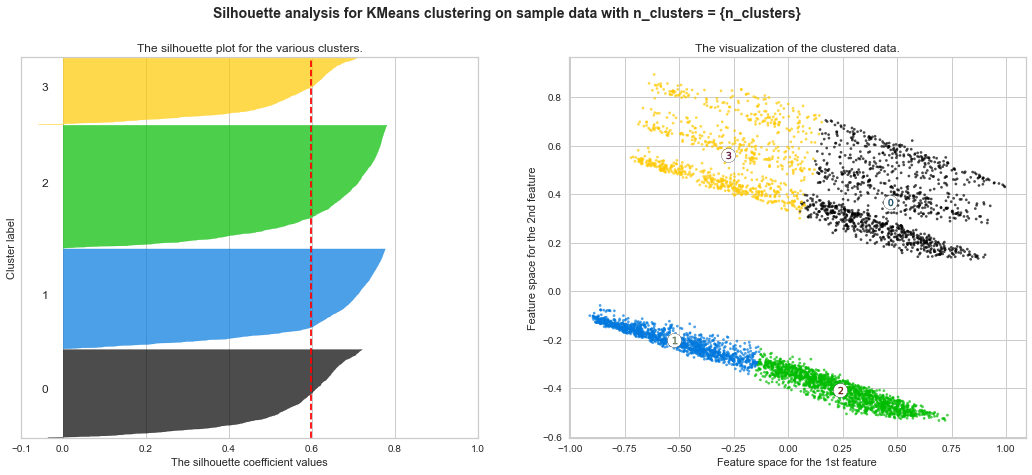

In [332]:
# QuantileTransformer(random_state=0)
# Create a subplot with 1 row and 2 columns
n_clusters = 4
n_components = 3
fig, (ax1, ax2) = plt.subplots(1, 2)
fig.set_size_inches(18, 7)

# The 1st subplot is the silhouette plot
# The silhouette coefficient can range from -1, 1 but in this example all
# lie within [-0.1, 1]
ax1.set_xlim([-0.1, 1])
# The (n_clusters+1)*10 is for inserting blank space between silhouette
# plots of individual clusters, to demarcate them clearly.
ax1.set_ylim([0, len(df_customer_1tr) + (3 + 1) * 10])

# Initialize the clusterer with n_clusters value and a random generator
# seed of 10 for reproducibility.
reduced_data = PCA(n_components=2).fit_transform(dfc_1tr_quantrans)
kmeans = KMeans(n_clusters=n_clusters)
# kmeans.fit(reduced_data)
estimator_QuantileTransformer = make_pipeline(QuantileTransformer(random_state=0),
                                              PCA(n_components=n_components), kmeans).fit(df_customer_1tr)
cluster_labels = kmeans.labels_

# The silhouette_score gives the average value for all the samples.
# This gives a perspective into the density and separation of the formed
# clusters
silhouette_avg = silhouette_score(reduced_data, cluster_labels)
print("For n_clusters =", n_clusters,
      "The average silhouette_score is :", silhouette_avg)

# Compute the silhouette scores for each sample
sample_silhouette_values = silhouette_samples(reduced_data, cluster_labels)

y_lower = 10
for i in range(n_clusters):
    # Aggregate the silhouette scores for samples belonging to
    # cluster i, and sort them
    ith_cluster_silhouette_values = \
        sample_silhouette_values[cluster_labels == i]

    ith_cluster_silhouette_values.sort()

    size_cluster_i = ith_cluster_silhouette_values.shape[0]
    y_upper = y_lower + size_cluster_i

    color = cm.nipy_spectral(float(i) / n_clusters)
    ax1.fill_betweenx(np.arange(y_lower, y_upper),
                      0, ith_cluster_silhouette_values,
                      facecolor=color, edgecolor=color, alpha=0.7)

    # Label the silhouette plots with their cluster numbers at the middle
    ax1.text(-0.05, y_lower + 0.5 * size_cluster_i, str(i))

    # Compute the new y_lower for next plot
    y_lower = y_upper + 10  # 10 for the 0 samples

ax1.set_title("The silhouette plot for the various clusters.")
ax1.set_xlabel("The silhouette coefficient values")
ax1.set_ylabel("Cluster label")

# The vertical line for average silhouette score of all the values
ax1.axvline(x=silhouette_avg, color="red", linestyle="--")

ax1.set_yticks([])  # Clear the yaxis labels / ticks
ax1.set_xticks([-0.1, 0, 0.2, 0.4, 0.6, 0.8, 1])

# 2nd Plot showing the actual clusters formed
colors = cm.nipy_spectral(cluster_labels.astype(float) / n_clusters)
ax2.scatter(reduced_data[:, 0], reduced_data[:, 1], marker='.', s=30, lw=0, alpha=0.7,
            c=colors, edgecolor='k')

# Labeling the clusters
centers = kmeans.cluster_centers_
# Draw white circles at cluster centers
ax2.scatter(centers[:, 0], centers[:, 1], marker='o',
            c="white", alpha=1, s=200, edgecolor='k')

for i, c in enumerate(centers):
    ax2.scatter(c[0], c[1], marker='$%d$' % i, alpha=1,
                s=50, edgecolor='k')

ax2.set_title("The visualization of the clustered data.")
ax2.set_xlabel("Feature space for the 1st feature")
ax2.set_ylabel("Feature space for the 2nd feature")

plt.suptitle((f"Silhouette analysis for KMeans clustering on sample data "
              "with n_clusters = {n_clusters}"),
             fontsize=14, fontweight='bold')

plt.show()

### Description des tranches du dataframe
df_customer_2tr <br/>
size: 17617, min: 2017-01-05 11:56:06, max: 2017-06-30 23:20:08<br/>
delta min: 0 days 00:00:00, max: 176 days 11:24:02<br/>
df_customer_3tr <br/>
size: 33031, min: 2017-01-05 11:56:06, max: 2017-09-30 23:59:15<br/>
delta min: 0 days 00:00:00, max: 268 days 12:03:09<br/>
df_customer_4tr <br/>
size: 54552, min: 2017-01-05 11:56:06, max: 2017-12-31 23:29:31<br/>
delta min: 0 days 00:00:00, max: 360 days 11:33:25<br/>
df_customer_5tr <br/>
size: 79882, min: 2017-01-05 11:56:06, max: 2018-03-31 23:54:10<br/>
delta min: 0 days 00:00:00, max: 450 days 11:58:04<br/>
df_customer_6tr <br/>
size: 103821, min: 2017-01-05 11:56:06, max: 2018-06-30 23:59:49<br/>
delta min: 0 days 00:00:00, max: 541 days 12:03:43<br/>
df_customer_7tr <br/>
size: 118737, min: 2017-01-05 11:56:06, max: 2018-09-29 09:13:03<br/>
delta min: 0 days 00:00:00, max: 631 days 21:16:57<br/>

In [186]:
df_customer_1tr_clusted = df_customer_1tr.copy()

In [216]:
df_customer_1tr_clusted.index

Index(['0000f46a3911fa3c0805444483337064', '0005e1862207bf6ccc02e4228effd9a0',
       '00115fc7123b5310cf6d3a3aa932699e', '001f3c4211216384d5fe59b041ce1461',
       '002043098f10ba39a4600b6c52fbfe3c', '002b4cd83fabaffaa475f78ea5ef3e08',
       '0037d2bbb9ebc39d9114aea27ee16d72', '003e28cb6fab8a0901bff9229612375f',
       '00446a03d7a34d191507c9e42870d0a5', '0049db44bfd6cee26ac9c649329ff6ea',
       ...
       'ff9bc66daa6702543b16f3c4897e300b', 'ffa17ff63f95ea3c838670e61d2666e0',
       'ffa46fd1f769dfbdd6c039550b420949', 'ffafb9f09293653c2486abe52e5e05a4',
       'ffba9f9dff87b05e310ecc46c8591044', 'ffe2dd1f3b0cbf0b5f35e818ec03c49b',
       'ffe3e199b9d0b7fb7d2d29a5b9498447', 'ffebb6424578e7bb153322da9d65634f',
       'ffedff0547d809c90c05c2691c51f9b7', 'ffff371b4d645b6ecea244b27531430a'],
      dtype='object', name='customer_unique_id', length=4849)

In [187]:
df_customer_1tr_clusted['cluster_labels'] = pd.Categorical(cluster_labels)

<Figure size 576x396 with 0 Axes>

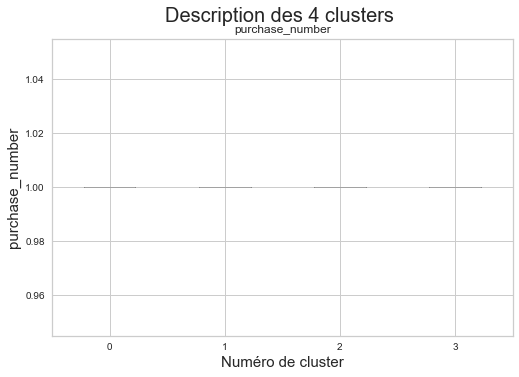

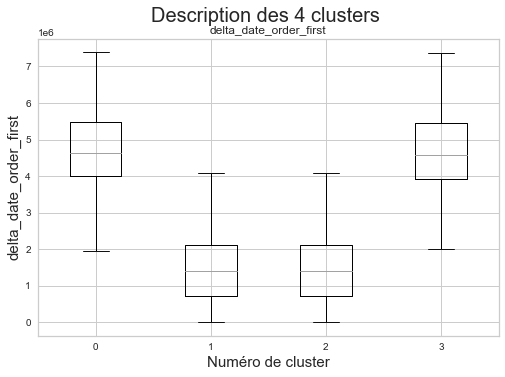

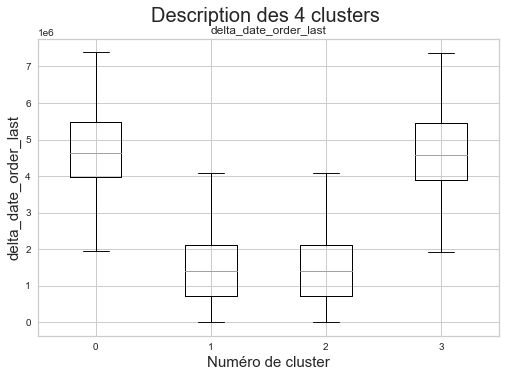

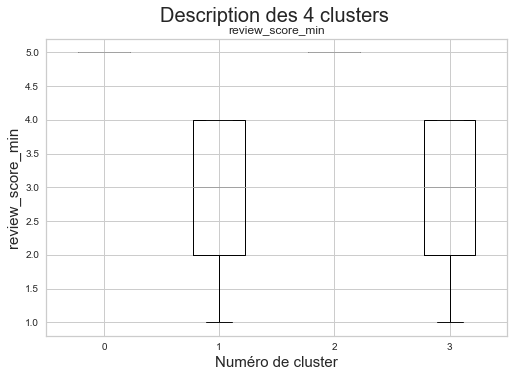

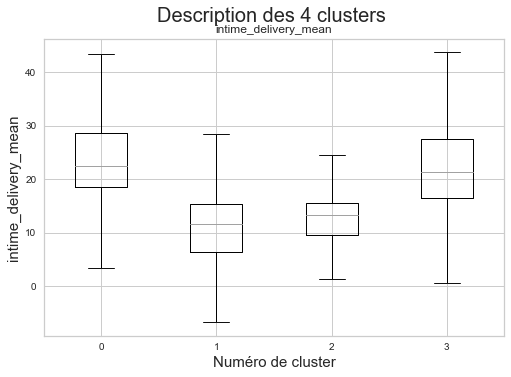

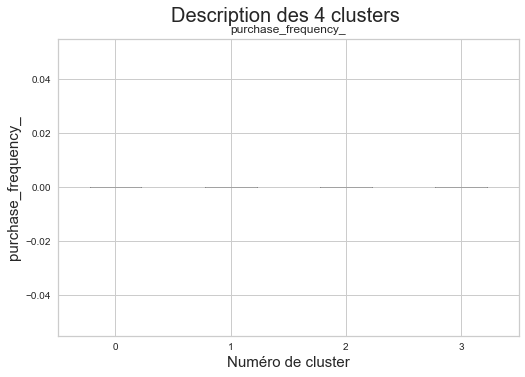

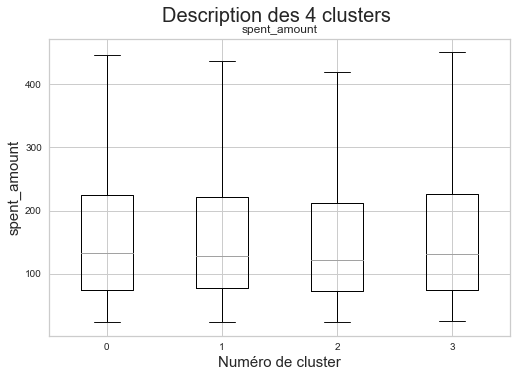

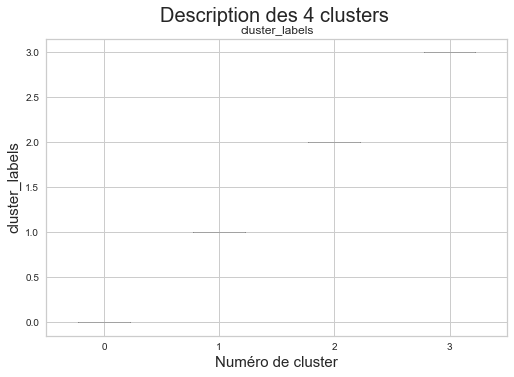

In [190]:
plt.figure()

for col in df_customer_1tr_clusted.columns:
    df_customer_1tr_clusted.boxplot(column=[col], by= df_customer_1tr_clusted['cluster_labels'], showfliers=False)
# plt.title('AAA')
    plt.suptitle(f'Description des {len(np.unique(cluster_labels))} clusters ', fontsize = 20) # 
    plt.xlabel('Numéro de cluster', fontsize = 15) # x-axis label with fontsize 15
    plt.ylabel(f'{col}', fontsize = 15) # y-axis label with fontsize 15
    plt.show()

In [191]:
df_customer_1tr_clusted['cluster_name'] = np.where((df_customer_1tr_clusted['cluster_labels'] == 0),'client_recent_satisfait', df_customer_1tr_clusted['cluster_labels'])

In [192]:
df_customer_1tr_clusted['cluster_name'] = np.where((df_customer_1tr_clusted['cluster_labels'] == 1),'nouveau_client_mécontant', df_customer_1tr_clusted['cluster_name'])

In [193]:
df_customer_1tr_clusted['cluster_name'] = np.where((df_customer_1tr_clusted['cluster_labels'] == 2),'nouveau_client_satisfait', df_customer_1tr_clusted['cluster_name'])

In [194]:
df_customer_1tr_clusted['cluster_name'] = np.where((df_customer_1tr_clusted['cluster_labels'] == 3),'client_recent_mécontant', df_customer_1tr_clusted['cluster_name'])

In [199]:
labels_1tr = df_customer_1tr_clusted['cluster_name'].unique().tolist()

In [200]:
labels_1tr

['nouveau_client_mécontant',
 'client_recent_mécontant',
 'nouveau_client_satisfait',
 'client_recent_satisfait']

In [333]:
y_pred_2tr = estimator_QuantileTransformer.predict(df_customer_2tr)

In [334]:
estimator_QuantileTransformer[2].cluster_centers_

array([[ 0.46957797,  0.36900558, -0.00610455],
       [-0.523746  , -0.20191993, -0.00281582],
       [ 0.23976373, -0.40565689, -0.00368892],
       [-0.27681072,  0.56313839,  0.01908981]])

In [335]:
estimator_QuantileTransformer.score(df_customer_2tr)

-1928.0316413241103

In [336]:
y_pred_2tr_fit = estimator_QuantileTransformer.fit_predict(df_customer_2tr)

In [337]:
y_pred_2tr_fit

array([2, 2, 2, ..., 3, 0, 3])

In [338]:
ari_2tr = adjusted_rand_score(y_pred_2tr_fit, y_pred_2tr)

In [339]:
ari_2tr

0.5269982171517392

In [340]:
df_ari_time_stability = pd.DataFrame(columns=['df_customer', 'ari_score'])

In [341]:
df_ari_time_stability = df_ari_time_stability.append({'df_customer':'2tr', 'ari_score':ari_2tr}, ignore_index=True)
# df_ari_time_stability = df_ari_time_stability.set_index('df_customer')

In [342]:
df_ari_time_stability

,df_customer,ari_score
0,2tr,0.526998


In [343]:
y_pred_3tr = estimator_QuantileTransformer.predict(df_customer_3tr)
y_pred_3tr_fit = estimator_QuantileTransformer.fit_predict(df_customer_3tr)
ari_3tr = adjusted_rand_score(y_pred_3tr, y_pred_3tr_fit)
df_ari_time_stability = df_ari_time_stability.append({'df_customer':'3tr', 'ari_score':ari_3tr}, ignore_index=True)
# df_ari_time_stability = df_ari_time_stability.set_index('df_customer')
df_ari_time_stability

,df_customer,ari_score
0,2tr,0.526998
1,3tr,0.666038


In [344]:
y_pred_4tr = estimator_QuantileTransformer.predict(df_customer_4tr)
y_pred_4tr_fit = estimator_QuantileTransformer.fit_predict(df_customer_4tr)
ari_4tr = adjusted_rand_score(y_pred_4tr, y_pred_4tr_fit)
df_ari_time_stability = df_ari_time_stability.append({'df_customer':'4tr', 'ari_score':ari_4tr}, ignore_index=True)
# df_ari_time_stability = df_ari_time_stability.set_index('df_customer')
df_ari_time_stability

,df_customer,ari_score
0,2tr,0.526998
1,3tr,0.666038
2,4tr,0.830736


In [345]:
y_pred_5tr = estimator_QuantileTransformer.predict(df_customer_5tr)
y_pred_5tr_fit = estimator_QuantileTransformer.fit_predict(df_customer_5tr)
ari_5tr = adjusted_rand_score(y_pred_5tr, y_pred_5tr_fit)
df_ari_time_stability = df_ari_time_stability.append({'df_customer':'5tr', 'ari_score':ari_5tr}, ignore_index=True)
# df_ari_time_stability = df_ari_time_stability.set_index('df_customer')
df_ari_time_stability

,df_customer,ari_score
0,2tr,0.526998
1,3tr,0.666038
2,4tr,0.830736
3,5tr,0.831332


In [346]:
y_pred_6tr = estimator_QuantileTransformer.predict(df_customer_6tr)
y_pred_6tr_fit = estimator_QuantileTransformer.fit_predict(df_customer_6tr)
ari_6tr = adjusted_rand_score(y_pred_6tr_fit, y_pred_6tr)
df_ari_time_stability = df_ari_time_stability.append({'df_customer':'6tr', 'ari_score':ari_6tr}, ignore_index=True)
# df_ari_time_stability = df_ari_time_stability.set_index('df_customer')
df_ari_time_stability

C:\Users\piari\AppData\Roaming\Python\Python38\site-packages\sklearn\metrics\cluster\_supervised.py:389: RuntimeWarning:

overflow encountered in longlong_scalars



,df_customer,ari_score
0,2tr,0.526998
1,3tr,0.666038
2,4tr,0.830736
3,5tr,0.831332
4,6tr,-7.010384


In [347]:
y_pred_7tr = estimator_QuantileTransformer.predict(df_customer_7tr)
y_pred_7tr_fit = estimator_QuantileTransformer.fit_predict(df_customer_7tr)
ari_7tr = adjusted_rand_score(y_pred_7tr_fit, y_pred_7tr)
df_ari_time_stability = df_ari_time_stability.append({'df_customer':'7tr', 'ari_score':ari_7tr}, ignore_index=True)
df_ari_time_stability

C:\Users\piari\AppData\Roaming\Python\Python38\site-packages\sklearn\metrics\cluster\_supervised.py:389: RuntimeWarning:

overflow encountered in longlong_scalars

C:\Users\piari\AppData\Roaming\Python\Python38\site-packages\sklearn\metrics\cluster\_supervised.py:390: RuntimeWarning:

overflow encountered in longlong_scalars



,df_customer,ari_score
0,2tr,0.526998
1,3tr,0.666038
2,4tr,0.830736
3,5tr,0.831332
4,6tr,-7.010384
5,7tr,2.121151


In [348]:
df_ari_time_stability = df_ari_time_stability.set_index('df_customer')

In [349]:
df_ari_time_stability

,ari_score
df_customer,
2tr,0.526998
3tr,0.666038
4tr,0.830736
5tr,0.831332
6tr,-7.010384
7tr,2.121151


Text(0, 0.5, 'Score')

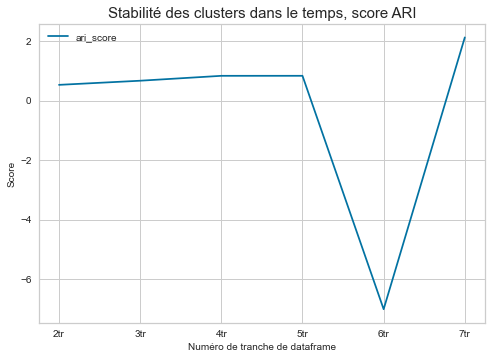

In [350]:
df_ari_time_stability.plot()
plt.title('Stabilité des clusters dans le temps, score ARI', fontsize = 15) # title with fontsize 25
plt.xlabel('Numéro de tranche de dataframe', fontsize = 10) # x-axis label with fontsize 15
plt.ylabel('Score', fontsize = 10) # y-axis label with fontsize 15

Text(0, 0.5, 'Score')

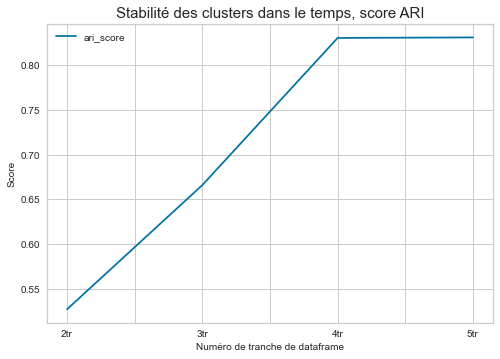

In [351]:
df_ari_time_stability.iloc[0:4,:].plot()
plt.title('Stabilité des clusters dans le temps, score ARI', fontsize = 15) # title with fontsize 25
plt.xlabel('Numéro de tranche de dataframe', fontsize = 10) # x-axis label with fontsize 15
plt.ylabel('Score', fontsize = 10) # y-axis label with fontsize 15

In [222]:
df_customer_1tr_clusted

,purchase_number,delta_date_order_first,delta_date_order_last,review_score_min,intime_delivery_mean,purchase_frequency_,spent_amount,cluster_labels,cluster_name
customer_unique_id,,,,,,,,,
0000f46a3911fa3c0805444483337064,1,1824582.0,1824582.0,3,1.389734,0.0,103.44,1,nouveau_client_mécontant
0005e1862207bf6ccc02e4228effd9a0,1,2334153.0,2334153.0,4,27.643657,0.0,165.24,3,client_recent_mécontant
00115fc7123b5310cf6d3a3aa932699e,1,5968570.0,5968570.0,4,32.085000,0.0,92.23,3,client_recent_mécontant
001f3c4211216384d5fe59b041ce1461,1,1056009.0,1056009.0,3,10.679456,0.0,46.80,1,nouveau_client_mécontant
002043098f10ba39a4600b6c52fbfe3c,1,457726.0,457726.0,4,15.597882,0.0,298.63,1,nouveau_client_mécontant
...,...,...,...,...,...,...,...,...,...
ffe2dd1f3b0cbf0b5f35e818ec03c49b,1,2255467.0,2255467.0,4,8.543241,0.0,131.41,1,nouveau_client_mécontant
ffe3e199b9d0b7fb7d2d29a5b9498447,1,1406289.0,1406289.0,1,-0.783403,0.0,177.30,1,nouveau_client_mécontant
ffebb6424578e7bb153322da9d65634f,1,6429034.0,6429034.0,1,4.789398,0.0,702.40,3,client_recent_mécontant


In [243]:
df_customer_1tr_clusted.reset_index().groupby(['cluster_labels']).agg({'customer_unique_id':'nunique'})

,customer_unique_id
cluster_labels,
0,1283
1,1130
2,1579
3,857


In [229]:
df_sankey = df_customer_1tr_clusted.reset_index().groupby(['cluster_labels']).agg({'customer_unique_id':'nunique'})

In [244]:
df_sankey

,customer_unique_id
cluster_labels,
0,1283
1,1130
2,1579
3,857


In [261]:
df_sankey.rename(columns={"customer_unique_id": "customers_n_3mois"}, inplace = True)

In [262]:
df_sankey

,customers_n_3mois
cluster_labels,
0,1283
1,1130
2,1579
3,857


In [251]:
tr_2_count = np.array(np.unique(y_pred_2tr, return_counts=True)).T

In [263]:
df_pred_tr2_count = pd.DataFrame(tr_2_count, columns = ['cluster_labels','customers_n_6mois'])

In [264]:
df_pred_tr2_count = df_pred_tr2_count.set_index('cluster_labels')

In [265]:
df_pred_tr2_count

,customers_n_6mois
cluster_labels,
0,5688
1,1518
2,2322
3,4065


In [286]:
df_total_count = df_sankey.merge(df_pred_tr2_count, on='cluster_labels')
df_total_count

,customers_n_3mois,customers_n_6mois
cluster_labels,,
0,1283,5688
1,1130,1518
2,1579,2322
3,857,4065


In [271]:
tr_3_count = np.array(np.unique(y_pred_3tr, return_counts=True)).T

In [272]:
df_pred_tr3_count = pd.DataFrame(tr_3_count, columns = ['cluster_labels','customers_n_9mois'])

In [273]:
df_pred_tr3_count = df_pred_tr3_count.set_index('cluster_labels')
df_pred_tr3_count

,customers_n_9mois
cluster_labels,
0,5786
1,6551
2,9480
3,3591


In [287]:
df_total_count = df_total_count.merge(df_pred_tr3_count, on='cluster_labels')
df_total_count

,customers_n_3mois,customers_n_6mois,customers_n_9mois
cluster_labels,,,
0,1283,5688,5786
1,1130,1518,6551
2,1579,2322,9480
3,857,4065,3591


In [275]:
tr_4_count = np.array(np.unique(y_pred_4tr, return_counts=True)).T

In [276]:
df_pred_tr4_count = pd.DataFrame(tr_4_count, columns = ['cluster_labels','customers_n_12mois'])

In [277]:
df_pred_tr4_count = df_pred_tr4_count.set_index('cluster_labels')
df_pred_tr4_count

,customers_n_12mois
cluster_labels,
0,9472
1,10567
2,13988
3,8107


In [288]:
df_total_count = df_total_count.merge(df_pred_tr4_count, on='cluster_labels')
df_total_count

,customers_n_3mois,customers_n_6mois,customers_n_9mois,customers_n_12mois
cluster_labels,,,,
0,1283,5688,5786,9472
1,1130,1518,6551,10567
2,1579,2322,9480,13988
3,857,4065,3591,8107


In [279]:
tr_5_count = np.array(np.unique(y_pred_5tr, return_counts=True)).T

In [283]:
df_pred_tr5_count = pd.DataFrame(tr_5_count, columns = ['cluster_labels','customers_n_15mois'])

In [284]:
df_pred_tr5_count = df_pred_tr5_count.set_index('cluster_labels')
df_pred_tr5_count

,customers_n_15mois
cluster_labels,
0,13102
1,19892
2,15100
3,13947


In [289]:
df_total_count = df_total_count.merge(df_pred_tr5_count, on='cluster_labels')
df_total_count

,customers_n_3mois,customers_n_6mois,customers_n_9mois,customers_n_12mois,customers_n_15mois
cluster_labels,,,,,
0,1283,5688,5786,9472,13102
1,1130,1518,6551,10567,19892
2,1579,2322,9480,13988,15100
3,857,4065,3591,8107,13947


In [290]:
tr_6_count = np.array(np.unique(y_pred_6tr, return_counts=True)).T

In [291]:
df_pred_tr6_count = pd.DataFrame(tr_6_count, columns = ['cluster_labels','customers_n_18mois'])

In [292]:
df_pred_tr6_count = df_pred_tr6_count.set_index('cluster_labels')
df_pred_tr6_count

,customers_n_18mois
cluster_labels,
0,18234
1,13728
2,28361
3,20684


In [293]:
df_total_count = df_total_count.merge(df_pred_tr6_count, on='cluster_labels')
df_total_count

,customers_n_3mois,customers_n_6mois,customers_n_9mois,customers_n_12mois,customers_n_15mois,customers_n_18mois
cluster_labels,,,,,,
0,1283,5688,5786,9472,13102,18234
1,1130,1518,6551,10567,19892,13728
2,1579,2322,9480,13988,15100,28361
3,857,4065,3591,8107,13947,20684


In [294]:
tr_7_count = np.array(np.unique(y_pred_7tr, return_counts=True)).T

In [295]:
df_pred_tr7_count = pd.DataFrame(tr_7_count, columns = ['cluster_labels','customers_n_21mois'])

In [297]:
df_pred_tr7_count = df_pred_tr7_count.set_index('cluster_labels')
df_pred_tr7_count

,customers_n_21mois
cluster_labels,
0,25504
1,13286
2,20471
3,33836


In [298]:
df_total_count = df_total_count.merge(df_pred_tr7_count, on='cluster_labels')
df_total_count

,customers_n_3mois,customers_n_6mois,customers_n_9mois,customers_n_12mois,customers_n_15mois,customers_n_18mois,customers_n_21mois
cluster_labels,,,,,,,
0,1283,5688,5786,9472,13102,18234,25504
1,1130,1518,6551,10567,19892,13728,13286
2,1579,2322,9480,13988,15100,28361,20471
3,857,4065,3591,8107,13947,20684,33836


In [308]:
df_total_count.T

cluster_labels,0,1,2,3
customers_n_3mois,1283,1130,1579,857
customers_n_6mois,5688,1518,2322,4065
customers_n_9mois,5786,6551,9480,3591
customers_n_12mois,9472,10567,13988,8107
customers_n_15mois,13102,19892,15100,13947
customers_n_18mois,18234,13728,28361,20684
customers_n_21mois,25504,13286,20471,33836


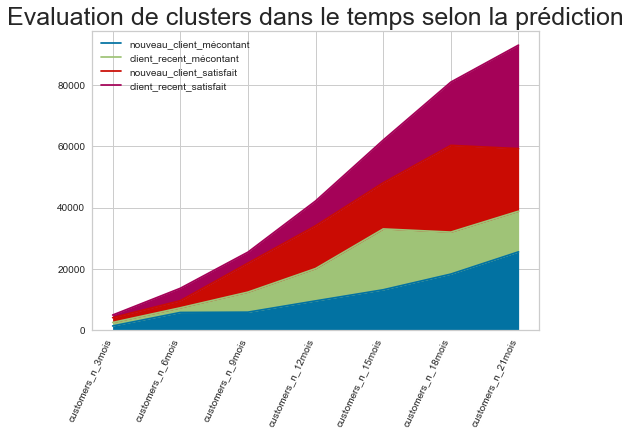

In [320]:
df_total_count.T.plot.area(stacked=True)
plt.legend(loc='upper left', bbox_to_anchor=(1.0, 1.01), frameon=False)
plt.title('Evaluation de clusters dans le temps selon la prédiction', fontsize = 25) # title with fontsize 25
plt.xticks(rotation=65, ha='right')
plt.legend(labels_1tr)

In [232]:
df_sankey['customer_unique_id'].tolist()

[1283, 1130, 1579, 857]

In [226]:
df_customer_1tr_clusted.groupby(['cluster_labels'])

4

In [234]:
labels_1tr

['nouveau_client_mécontant',
 'client_recent_mécontant',
 'nouveau_client_satisfait',
 'client_recent_satisfait']

In [313]:
fig = go.Figure(data=[go.Sankey(
    node = dict(
      pad = 15,
      thickness = 20,
      line = dict(color = "black", width = 0.5),
      label = labels_1tr * 7,
      color = "blue"
    ),
    link = dict(
      #source = df_customer_1tr_clusted['cluster_labels'].tolist(), # indices correspond to labels, eg A1, A2, A1, B1, ...
      #target = y_pred_2tr_fit,
      #value = df_sankey['customer_unique_id'].tolist()
        source = list(range((7-1)*4)),
        target = list(range(4,(7*4))),
        value = [1] * (7*4)
  ))])

fig.update_layout(title_text="Basic Sankey Diagram", font_size=10)
fig.show()

In [105]:
! pip install jupyter_contrib_nbextensions

  Created wheel for jupyter-latex-envs: filename=jupyter_latex_envs-1.4.6-py2.py3-none-any.whl size=963398 sha256=83967b711269891a47d4a83b29342c6eb91df8cc71274b72b8c123b9a0e66889
  Stored in directory: c:\users\piari\appdata\local\pip\cache\wheels\4d\ba\f4\b8c0941055519ebc0f27e85bfe2bb223f1a59a3b8bfc5c7515
  Created wheel for jupyter-nbextensions-configurator: filename=jupyter_nbextensions_configurator-0.4.1-py2.py3-none-any.whl size=465828 sha256=faaa4f57820c9a76a681ec0ac50a2c1ac032d2dc59101992703f766593279980
  Stored in directory: c:\users\piari\appdata\local\pip\cache\wheels\e3\3a\b3\a709b437602c3807f079f0c35ccba3e1adf9af6f2e6b0ebfea
Successfully built jupyter-latex-envs jupyter-nbextensions-configurator


In [106]:
! pip install jupyter_nbextensions_configurator

In [108]:
! jupyter contrib nbextension install --user

[I 16:50:05 InstallContribNbextensionsApp] jupyter contrib nbextension install --user
[I 16:50:05 InstallContribNbextensionsApp] Installing jupyter_contrib_nbextensions nbextension files to jupyter data directory
[I 16:50:05 InstallContribNbextensionsApp] Installing c:\programdata\anaconda3\lib\site-packages\jupyter_contrib_nbextensions\nbextensions\addbefore -> addbefore
[I 16:50:05 InstallContribNbextensionsApp] Making directory: C:\Users\piari\AppData\Roaming\jupyter\nbextensions\addbefore\
[I 16:50:05 InstallContribNbextensionsApp] Copying: c:\programdata\anaconda3\lib\site-packages\jupyter_contrib_nbextensions\nbextensions\addbefore\addbefore.yaml -> C:\Users\piari\AppData\Roaming\jupyter\nbextensions\addbefore\addbefore.yaml
[I 16:50:05 InstallContribNbextensionsApp] Copying: c:\programdata\anaconda3\lib\site-packages\jupyter_contrib_nbextensions\nbextensions\addbefore\icon.png -> C:\Users\piari\AppData\Roaming\jupyter\nbextensions\addbefore\icon.png
[I 16:50:05 InstallContribNbe

[I 16:50:05 InstallContribNbextensionsApp] Up to date: C:\Users\piari\AppData\Roaming\jupyter\nbextensions\code_prettify\README_autopep8.md
[I 16:50:05 InstallContribNbextensionsApp] Up to date: C:\Users\piari\AppData\Roaming\jupyter\nbextensions\code_prettify\README_code_prettify.md
[I 16:50:05 InstallContribNbextensionsApp] Up to date: C:\Users\piari\AppData\Roaming\jupyter\nbextensions\code_prettify\README_isort.md
[I 16:50:05 InstallContribNbextensionsApp] - Validating: ok
[I 16:50:05 InstallContribNbextensionsApp] Installing c:\programdata\anaconda3\lib\site-packages\jupyter_contrib_nbextensions\nbextensions\code_prettify -> code_prettify
[I 16:50:05 InstallContribNbextensionsApp] Up to date: C:\Users\piari\AppData\Roaming\jupyter\nbextensions\code_prettify\2to3.js
[I 16:50:05 InstallContribNbextensionsApp] Up to date: C:\Users\piari\AppData\Roaming\jupyter\nbextensions\code_prettify\2to3.yaml
[I 16:50:05 InstallContribNbextensionsApp] Up to date: C:\Users\piari\AppData\Roaming\ju

[I 16:50:05 InstallContribNbextensionsApp] Copying: c:\programdata\anaconda3\lib\site-packages\jupyter_contrib_nbextensions\nbextensions\export_embedded\export_embedded.yaml -> C:\Users\piari\AppData\Roaming\jupyter\nbextensions\export_embedded\export_embedded.yaml
[I 16:50:05 InstallContribNbextensionsApp] Copying: c:\programdata\anaconda3\lib\site-packages\jupyter_contrib_nbextensions\nbextensions\export_embedded\icon.png -> C:\Users\piari\AppData\Roaming\jupyter\nbextensions\export_embedded\icon.png
[I 16:50:05 InstallContribNbextensionsApp] Copying: c:\programdata\anaconda3\lib\site-packages\jupyter_contrib_nbextensions\nbextensions\export_embedded\main.js -> C:\Users\piari\AppData\Roaming\jupyter\nbextensions\export_embedded\main.js
[I 16:50:05 InstallContribNbextensionsApp] Copying: c:\programdata\anaconda3\lib\site-packages\jupyter_contrib_nbextensions\nbextensions\export_embedded\readme.md -> C:\Users\piari\AppData\Roaming\jupyter\nbextensions\export_embedded\readme.md
[I 16:50

In [109]:
! jupyter nbextensions_configurator enable --user

Enabling: jupyter_nbextensions_configurator
- Writing config: C:\Users\piari\.jupyter
    - Validating...
      jupyter_nbextensions_configurator 0.4.1 ok
Enabling notebook nbextension nbextensions_configurator/config_menu/main...
Enabling tree nbextension nbextensions_configurator/tree_tab/main...


In [ ]:
# plt.savefig('05. Répartition clients - âge barplot.jpg', dpi=500, bbox_inches='tight', pad_inches=0.5) ou
# plt.tight_layout()

In [139]:
! pip install autopep8

In [140]:
! pip install flake8 pycodestyle_magic

In [141]:
%load_ext pycodestyle_magic

In [142]:
%install_ext https://raw.githubusercontent.com/SiggyF/notebooks/master/pep8_magic.py

UsageError: Line magic function `%install_ext` not found.


In [143]:
! jupyter nbextension install --user pep8_magic.py

Copying: pep8_magic.py -> C:\Users\piari\AppData\Roaming\jupyter\nbextensions\pep8_magic.py
Traceback (most recent call last):
  File "C:\ProgramData\Anaconda3\Scripts\jupyter-nbextension-script.py", line 10, in <module>
    sys.exit(main())
  File "C:\ProgramData\Anaconda3\lib\site-packages\jupyter_core\application.py", line 270, in launch_instance
    return super(JupyterApp, cls).launch_instance(argv=argv, **kwargs)
  File "C:\ProgramData\Anaconda3\lib\site-packages\traitlets\config\application.py", line 845, in launch_instance
    app.start()
  File "C:\ProgramData\Anaconda3\lib\site-packages\notebook\nbextensions.py", line 983, in start
    super(NBExtensionApp, self).start()
  File "C:\ProgramData\Anaconda3\lib\site-packages\jupyter_core\application.py", line 259, in start
    self.subapp.start()
  File "C:\ProgramData\Anaconda3\lib\site-packages\notebook\nbextensions.py", line 711, in start
    self.install_extensions()
  File "C:\ProgramData\Anaconda3\lib\site-packages\notebook

In [144]:
%load_ext pep8magic

ModuleNotFoundError: No module named 'pep8magic'

In [145]:
! pip install pep8

In [146]:
! pip install --upgrade pep8

Requirement already up-to-date: pep8 in c:\programdata\anaconda3\lib\site-packages (1.7.1)


In [147]:
! pip install autopep8

#### Analyse de stabilité du modèle entrainé sur 3 mois de données.

In [504]:
df_ari_time_stability2 = pd.DataFrame(columns=['data_quantity_in_months', 'ari_score', 'davis_bouldin_score'])

In [505]:
# QuantileTransformer(random_state=0)
# df_customer_1tr = 3 mois

n_clusters = 4
n_components = 3

kmeans = KMeans(n_clusters=n_clusters)
# kmeans.fit(reduced_data)
# estimator_QuantileTransformer_a restera toujours enchangé
estimator_QuantileTransformer_a = make_pipeline(QuantileTransformer(random_state=0),
                                              PCA(n_components=n_components), kmeans).fit(df_customer_1tr)
# estimator_QuantileTransformer_b sera toujours refitté
estimator_QuantileTransformer_b = make_pipeline(QuantileTransformer(random_state=0),
                                              PCA(n_components=n_components), kmeans).fit(df_customer_1tr)
cluster_labels_a = kmeans.labels_
db_score_a = davies_bouldin_score(df_customer_1tr.values, cluster_labels_a)

In [506]:
# df_customer_2tr = 6mois
y_pred_3mois = estimator_QuantileTransformer_a.predict(df_customer_1tr)

ari_3mois = adjusted_rand_score(y_pred_3mois, cluster_labels_a)

In [507]:
df_ari_time_stability2 = df_ari_time_stability2.append({'data_quantity_in_months':'3_mois', 'ari_score':ari_3mois, 'davis_bouldin_score':db_score_a}, ignore_index=True)
df_ari_time_stability2

,data_quantity_in_months,ari_score,davis_bouldin_score
0,3_mois,1.0,57.118263


In [508]:
# df_customer_2tr = 6mois
y_pred_6mois = estimator_QuantileTransformer_a.predict(df_customer_2tr)
y_pred_6mois_fit = estimator_QuantileTransformer_b.fit_predict(df_customer_2tr)
ari_6mois = adjusted_rand_score(y_pred_6mois, y_pred_6mois_fit)
db_score_6mois = davies_bouldin_score(df_customer_2tr.values, y_pred_6mois_fit)

In [509]:
df_ari_time_stability2 = df_ari_time_stability2.append({'data_quantity_in_months':'6_mois', 'ari_score':ari_6mois,
                                                        'davis_bouldin_score':db_score_6mois}, ignore_index=True)
# df_ari_time_stability = df_ari_time_stability.set_index('df_customer')
df_ari_time_stability2

,data_quantity_in_months,ari_score,davis_bouldin_score
0,3_mois,1.000000,57.118263
1,6_mois,0.526771,387.566271


In [510]:
# df_customer_3tr = 9mois
y_pred_9mois = estimator_QuantileTransformer_a.predict(df_customer_3tr)
y_pred_9mois_fit = estimator_QuantileTransformer_b.fit_predict(df_customer_3tr)
ari_9mois = adjusted_rand_score(y_pred_9mois, y_pred_9mois_fit)
db_score_9mois = davies_bouldin_score(df_customer_3tr.values, y_pred_9mois_fit)
df_ari_time_stability2 = df_ari_time_stability2.append({'data_quantity_in_months':'9_mois', 'ari_score':ari_9mois,
                                                        'davis_bouldin_score':db_score_9mois}, ignore_index=True)
# df_ari_time_stability = df_ari_time_stability.set_index('df_customer')
df_ari_time_stability2

,data_quantity_in_months,ari_score,davis_bouldin_score
0,3_mois,1.000000,57.118263
1,6_mois,0.526771,387.566271
2,9_mois,0.474716,105.942458


In [511]:
# df_customer_4tr = 12mois
y_pred_12mois = estimator_QuantileTransformer_a.predict(df_customer_4tr)
y_pred_12mois_fit = estimator_QuantileTransformer_b.fit_predict(df_customer_4tr)
ari_12mois = adjusted_rand_score(y_pred_12mois, y_pred_12mois_fit)
db_score_12mois = davies_bouldin_score(df_customer_4tr.values, y_pred_12mois_fit)
df_ari_time_stability2 = df_ari_time_stability2.append({'data_quantity_in_months':'12_mois', 'ari_score':ari_12mois,
                                                       'davis_bouldin_score':db_score_12mois},
                                                       ignore_index=True)
# df_ari_time_stability = df_ari_time_stability.set_index('df_customer')
df_ari_time_stability2

,data_quantity_in_months,ari_score,davis_bouldin_score
0,3_mois,1.000000,57.118263
1,6_mois,0.526771,387.566271
2,9_mois,0.474716,105.942458
3,12_mois,0.483868,58.529861


In [512]:
# df_customer_5tr = 15mois
y_pred_15mois = estimator_QuantileTransformer_a.predict(df_customer_5tr)
y_pred_15mois_fit = estimator_QuantileTransformer_b.fit_predict(df_customer_5tr)
ari_15mois = adjusted_rand_score(y_pred_15mois, y_pred_15mois_fit)
db_score_15mois = davies_bouldin_score(df_customer_5tr.values, y_pred_15mois_fit)
df_ari_time_stability2 = df_ari_time_stability2.append({'data_quantity_in_months':'15_mois', 'ari_score':ari_15mois,
                                                       'davis_bouldin_score':db_score_15mois},
                                                       ignore_index=True)
# df_ari_time_stability = df_ari_time_stability.set_index('df_customer')
df_ari_time_stability2

,data_quantity_in_months,ari_score,davis_bouldin_score
0,3_mois,1.000000,57.118263
1,6_mois,0.526771,387.566271
2,9_mois,0.474716,105.942458
3,12_mois,0.483868,58.529861
4,15_mois,0.423052,32.774979


In [513]:
# df_customer_6tr = 18mois
y_pred_18mois = estimator_QuantileTransformer_a.predict(df_customer_6tr)
y_pred_18mois_fit = estimator_QuantileTransformer_b.fit_predict(df_customer_6tr)
ari_18mois = adjusted_rand_score(y_pred_18mois, y_pred_18mois_fit)
db_score_18mois = davies_bouldin_score(df_customer_6tr.values, y_pred_18mois_fit)
df_ari_time_stability2 = df_ari_time_stability2.append({'data_quantity_in_months':'18_mois', 'ari_score':ari_18mois,
                                                       'davis_bouldin_score':db_score_18mois},
                                                       ignore_index=True)
# df_ari_time_stability = df_ari_time_stability.set_index('df_customer')
df_ari_time_stability2

C:\Users\piari\AppData\Roaming\Python\Python38\site-packages\sklearn\metrics\cluster\_supervised.py:389: RuntimeWarning:

overflow encountered in longlong_scalars



,data_quantity_in_months,ari_score,davis_bouldin_score
0,3_mois,1.000000,57.118263
1,6_mois,0.526771,387.566271
2,9_mois,0.474716,105.942458
3,12_mois,0.483868,58.529861
4,15_mois,0.423052,32.774979
5,18_mois,4.863618,30.617658


In [514]:
# df_customer_7tr = 21 mois
y_pred_21mois = estimator_QuantileTransformer_a.predict(df_customer_7tr)
y_pred_21mois_fit = estimator_QuantileTransformer_b.fit_predict(df_customer_7tr)
ari_21mois = adjusted_rand_score(y_pred_21mois, y_pred_21mois_fit)
db_score_21mois = davies_bouldin_score(df_customer_7tr.values, y_pred_21mois_fit)
df_ari_time_stability2 = df_ari_time_stability2.append({'data_quantity_in_months':'21_mois', 'ari_score':ari_21mois,
                                                       'davis_bouldin_score':db_score_21mois},
                                                       ignore_index=True)
# df_ari_time_stability = df_ari_time_stability.set_index('df_customer')
df_ari_time_stability2

C:\Users\piari\AppData\Roaming\Python\Python38\site-packages\sklearn\metrics\cluster\_supervised.py:389: RuntimeWarning:

overflow encountered in longlong_scalars



,data_quantity_in_months,ari_score,davis_bouldin_score
0,3_mois,1.000000,57.118263
1,6_mois,0.526771,387.566271
2,9_mois,0.474716,105.942458
3,12_mois,0.483868,58.529861
4,15_mois,0.423052,32.774979
5,18_mois,4.863618,30.617658
6,21_mois,-0.182105,64.227860


In [515]:
df_ari_time_stability2 = df_ari_time_stability2.set_index('data_quantity_in_months')

Text(0, 0.5, 'Score Davis Bouldin')

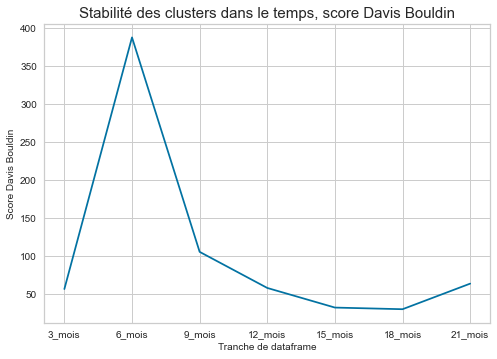

In [516]:
df_ari_time_stability2['davis_bouldin_score'].plot()
plt.title('Stabilité des clusters dans le temps, score Davis Bouldin', fontsize = 15) # title with fontsize 25
plt.xlabel('Tranche de dataframe', fontsize = 10) # x-axis label with fontsize 15
plt.ylabel('Score Davis Bouldin', fontsize = 10) # y-axis label with fontsize 15

Text(0, 0.5, 'Score ARI')

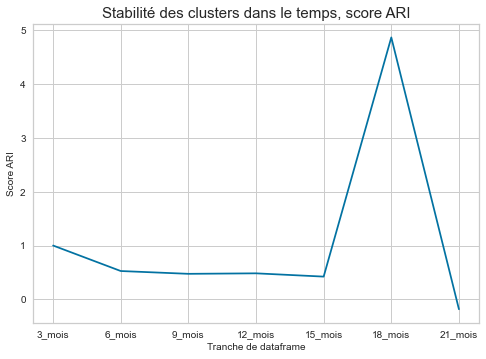

In [517]:
df_ari_time_stability2['ari_score'].plot()
plt.title('Stabilité des clusters dans le temps, score ARI', fontsize = 15) # title with fontsize 25
plt.xlabel('Tranche de dataframe', fontsize = 10) # x-axis label with fontsize 15
plt.ylabel('Score ARI', fontsize = 10) # y-axis label with fontsize 15

Text(0, 0.5, 'Score ARI')

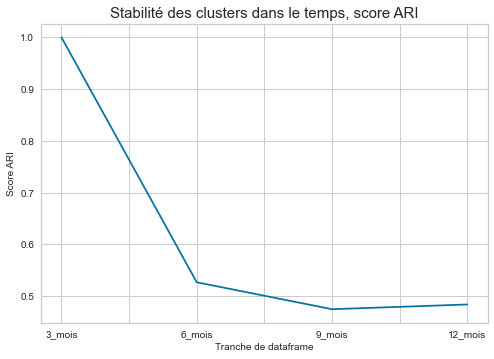

In [518]:
df_ari_time_stability2.iloc[0:4,:]['ari_score'].plot()
plt.title('Stabilité des clusters dans le temps, score ARI', fontsize = 15) # title with fontsize 25
plt.xlabel('Tranche de dataframe', fontsize = 10) # x-axis label with fontsize 15
plt.ylabel('Score ARI', fontsize = 10) # y-axis label with fontsize 15

#### Analyse de stabilité du modèle entrainé sur 12 mois de données.

In [493]:
df_time_stability_4tr = pd.DataFrame(columns=['data_quantity_in_months', 'ari_score', 'davis_bouldin_score'])

In [494]:
# QuantileTransformer(random_state=0)
# df_customer_1tr = 3 mois

n_clusters = 4
n_components = 3

kmeans = KMeans(n_clusters=n_clusters)
# kmeans.fit(reduced_data)
# estimator_QuantileTransformer_a restera toujours enchangé
estimator_QuantileTransformer12_a = make_pipeline(QuantileTransformer(random_state=0),
                                              PCA(n_components=n_components), kmeans).fit(df_customer_4tr)
# estimator_QuantileTransformer_b sera toujours refitté
estimator_QuantileTransformer12_b = make_pipeline(QuantileTransformer(random_state=0),
                                              PCA(n_components=n_components), kmeans).fit(df_customer_4tr)
cluster_labels12_a = kmeans.labels_
db_score12_a = davies_bouldin_score(df_customer_4tr.values, cluster_labels12_a)

In [520]:
cluster_labels12_a

array([1, 3, 0, ..., 3, 2, 2])

In [495]:
# df_customer_4tr = 12mois
y_pred_12mois = estimator_QuantileTransformer12_a.predict(df_customer_4tr)

ari_12mois = adjusted_rand_score(y_pred_12mois, cluster_labels12_a)

In [496]:
df_time_stability_4tr = df_time_stability_4tr.append({'data_quantity_in_months':'12_mois', 'ari_score':ari_12mois, 'davis_bouldin_score':db_score12_a}, ignore_index=True)
df_time_stability_4tr

,data_quantity_in_months,ari_score,davis_bouldin_score
0,12_mois,1.0,59.298083


In [497]:
# df_customer_5tr = 15mois
y_pred_15mois = estimator_QuantileTransformer12_a.predict(df_customer_5tr)
y_pred_15mois_fit = estimator_QuantileTransformer12_b.fit_predict(df_customer_5tr)
ari12_15mois = adjusted_rand_score(y_pred_15mois, y_pred_15mois_fit)
db_score12_15mois = davies_bouldin_score(df_customer_5tr.values, y_pred_15mois_fit)

In [521]:
y_pred_15mois_fit

array([3, 3, 2, ..., 1, 0, 0])

In [498]:
df_time_stability_4tr = df_time_stability_4tr.append({'data_quantity_in_months':'15_mois', 'ari_score':ari12_15mois,
                                                        'davis_bouldin_score':db_score12_15mois}, ignore_index=True)
df_time_stability_4tr

,data_quantity_in_months,ari_score,davis_bouldin_score
0,12_mois,1.000000,59.298083
1,15_mois,0.830363,31.363345


In [499]:
# df_customer_6tr = 18mois
y_pred_18mois = estimator_QuantileTransformer12_a.predict(df_customer_6tr)
y_pred_18mois_fit = estimator_QuantileTransformer12_b.fit_predict(df_customer_6tr)
ari12_18mois = adjusted_rand_score(y_pred_18mois, y_pred_18mois_fit)
db_score12_18mois = davies_bouldin_score(df_customer_6tr.values, y_pred_18mois_fit)
df_time_stability_4tr = df_time_stability_4tr.append({'data_quantity_in_months':'18_mois', 'ari_score':ari12_18mois,
                                                        'davis_bouldin_score':db_score12_18mois}, ignore_index=True)
df_time_stability_4tr

C:\Users\piari\AppData\Roaming\Python\Python38\site-packages\sklearn\metrics\cluster\_supervised.py:389: RuntimeWarning:

overflow encountered in longlong_scalars



,data_quantity_in_months,ari_score,davis_bouldin_score
0,12_mois,1.000000,59.298083
1,15_mois,0.830363,31.363345
2,18_mois,-7.266156,30.702423


In [500]:
# df_customer_7tr = 21mois
y_pred_21mois = estimator_QuantileTransformer12_a.predict(df_customer_7tr)
y_pred_21mois_fit = estimator_QuantileTransformer12_b.fit_predict(df_customer_7tr)
ari12_21mois = adjusted_rand_score(y_pred_21mois, y_pred_21mois_fit)
db_score12_21mois = davies_bouldin_score(df_customer_7tr.values, y_pred_21mois_fit)
df_time_stability_4tr = df_time_stability_4tr.append({'data_quantity_in_months':'21_mois', 'ari_score':ari12_21mois,
                                                        'davis_bouldin_score':db_score12_21mois}, ignore_index=True)
df_time_stability_4tr

C:\Users\piari\AppData\Roaming\Python\Python38\site-packages\sklearn\metrics\cluster\_supervised.py:389: RuntimeWarning:

overflow encountered in longlong_scalars

C:\Users\piari\AppData\Roaming\Python\Python38\site-packages\sklearn\metrics\cluster\_supervised.py:390: RuntimeWarning:

overflow encountered in longlong_scalars



,data_quantity_in_months,ari_score,davis_bouldin_score
0,12_mois,1.000000,59.298083
1,15_mois,0.830363,31.363345
2,18_mois,-7.266156,30.702423
3,21_mois,-3.332270,66.526485


In [501]:
df_time_stability_4tr = df_time_stability_4tr.set_index('data_quantity_in_months')

Text(0, 0.5, 'Score Davis Bouldin')

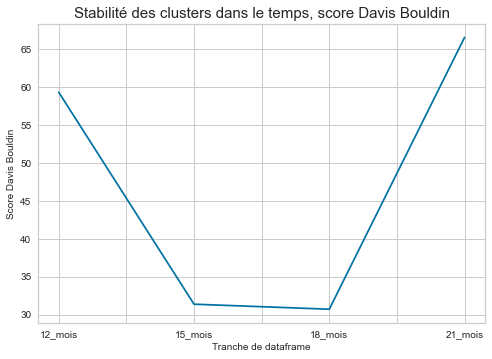

In [502]:
df_time_stability_4tr['davis_bouldin_score'].plot()
plt.title('Stabilité des clusters dans le temps, score Davis Bouldin', fontsize = 15) # title with fontsize 25
plt.xlabel('Tranche de dataframe', fontsize = 10) # x-axis label with fontsize 15
plt.ylabel('Score Davis Bouldin', fontsize = 10) # y-axis label with fontsize 15

Text(0, 0.5, 'Score ARI')

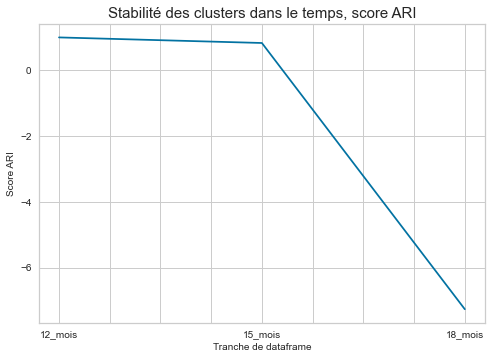

In [523]:
df_time_stability_4tr.iloc[0:3,:]['ari_score'].plot()
plt.title('Stabilité des clusters dans le temps, score ARI', fontsize = 15) # title with fontsize 25
plt.xlabel('Tranche de dataframe', fontsize = 10) # x-axis label with fontsize 15
plt.ylabel('Score ARI', fontsize = 10) # y-axis label with fontsize 15